In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, find_peaks, hilbert
from scipy.integrate import odeint

# === Load EEG data (replace with your path) ===
file_path = "/Users/kasunachinthaperera/Documents/VS Code/Complex Network/Data/EEG.csv"
EEG = pd.read_csv(file_path)

real_data_path = "/Users/kasunachinthaperera/Documents/VS Code/Complex Network/Data/Epileptogenic_Results.csv"
df = pd.read_csv(real_data_path)


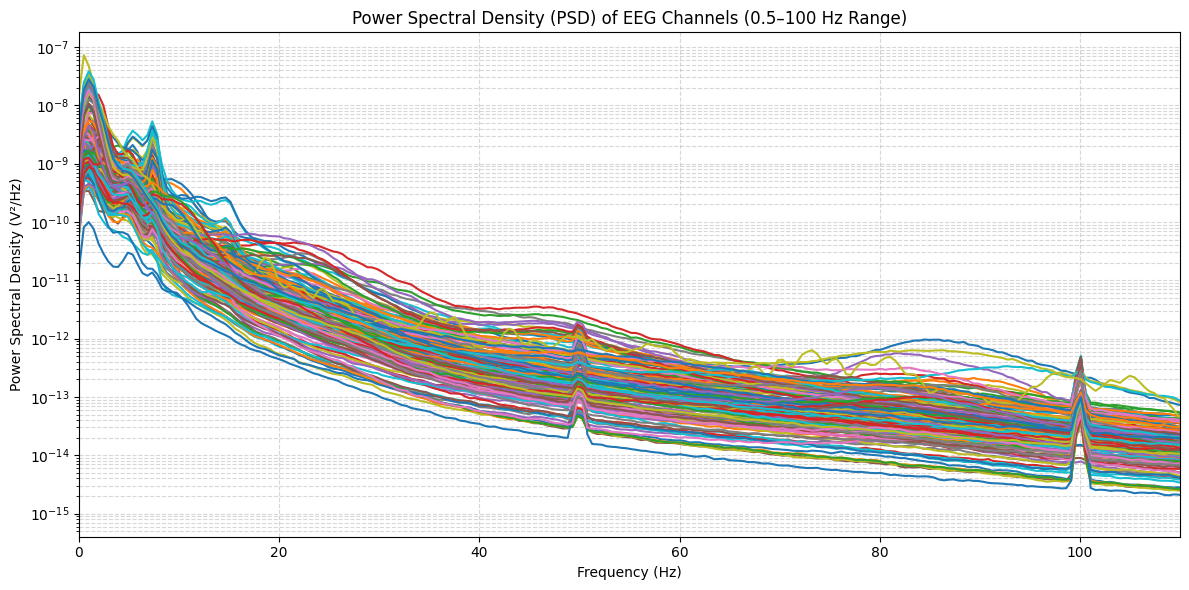

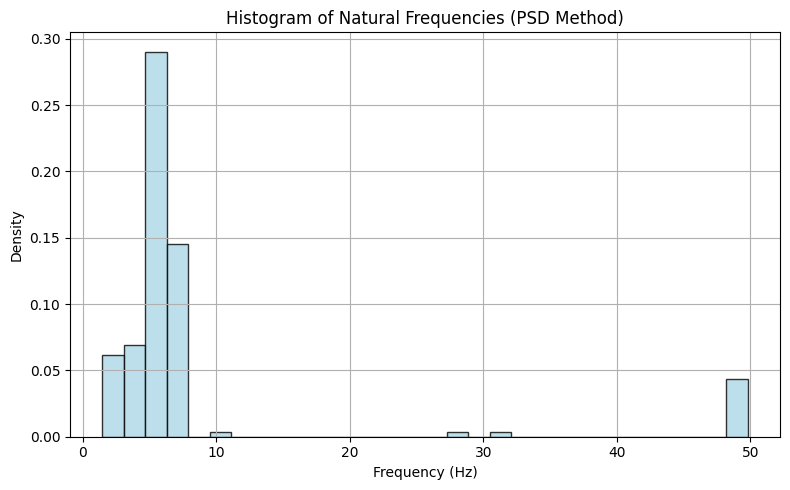

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, find_peaks
from numba import njit

# === Parameters ===
fs = 500  # Sampling frequency (Hz)
channels = EEG.columns
N = len(channels)

# === Step 1: Extract natural frequencies from PSD ===
natural_freqs = []

for channel in channels:
    signal = EEG[channel].values
    freqs, psd = welch(signal, fs=fs, nperseg=1024)

    mask = (freqs >= 0.5) & (freqs <= 100)
    freqs_band = freqs[mask]
    psd_band = psd[mask]

    peak_idx, _ = find_peaks(psd_band)

    if len(peak_idx) > 0:
        dominant_idx = peak_idx[np.argmax(psd_band[peak_idx])]
        natural_freq = freqs_band[dominant_idx]
    else:
        if np.sum(psd_band) > 0:
            natural_freq = np.sum(freqs_band * psd_band) / np.sum(psd_band)
        else:
            natural_freq = np.nan  # no power in band

    natural_freqs.append(natural_freq)

natural_freqs = np.array(natural_freqs)



# === Plot frequency spectrum of all channels ===
plt.figure(figsize=(12, 6))
for i, channel in enumerate(channels):
    signal = EEG[channel].values
    freqs, psd = welch(signal, fs=fs, nperseg=1024)
    plt.semilogy(freqs, psd, label=channel)

plt.xlim(0, 110)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V²/Hz)')
plt.title('Power Spectral Density (PSD) of EEG Channels (0.5–100 Hz Range)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === Plot histogram of natural frequencies ===
plt.figure(figsize=(8, 5))
valid_freqs = natural_freqs[~np.isnan(natural_freqs)]
plt.hist(valid_freqs, bins=30, density=True, color='lightblue', edgecolor='black', alpha=0.8)
plt.title("Histogram of Natural Frequencies (PSD Method)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()




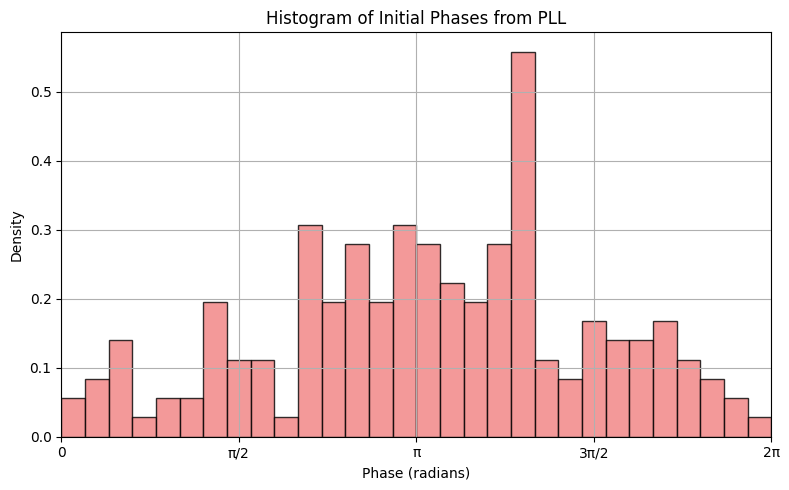

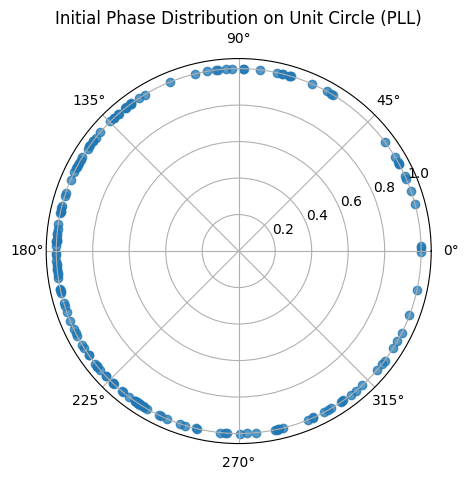

In [3]:
# === Numba-accelerated PLL function ===
@njit
def pll_frequency(signal, fs, f0, Kp=2.0, Ki=1.0):
    N = len(signal)
    dt = 1 / fs
    vco_phase = 0.0
    vco_freq = 2 * np.pi * f0
    integrator = 0.0
    freq_series = np.zeros(N)

    for n in range(N):
        ref = np.cos(vco_phase)
        error = signal[n] * ref
        integrator += Ki * error * dt
        control = Kp * error + integrator
        vco_freq = 2 * np.pi * f0 + control
        vco_phase += vco_freq * dt
        vco_phase %= 2 * np.pi
        freq_series[n] = vco_freq / (2 * np.pi)  # Hz

    return freq_series

# === Step 2: Run PLL per channel and get initial phases ===
initial_phases = []
pll_freqs_all = []

for i, channel in enumerate(channels):
    f0 = natural_freqs[i]

    if np.isnan(f0) or f0 <= 0:
        # Skip channels with invalid frequency
        continue

    signal = EEG[channel].values
    signal = signal - np.mean(signal)

    freq_series = pll_frequency(signal, fs, f0)
    pll_freqs_all.append(freq_series)
    cum_phase = np.cumsum(freq_series * 2 * np.pi / fs)  # rad
    phase = cum_phase[-1] % (2 * np.pi)
    initial_phases.append(phase)

initial_phases = np.array(initial_phases)

# === Plot histogram of initial phases from PLL ===
plt.figure(figsize=(8, 5))
plt.hist(initial_phases, bins=30, density=True, color='lightcoral', edgecolor='black', alpha=0.8, range=(0, 2*np.pi))
plt.title("Histogram of Initial Phases from PLL")
plt.xlabel("Phase (radians)")
plt.ylabel("Density")
plt.xlim([0, 2*np.pi])
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', 'π/2', 'π', '3π/2', '2π'])
plt.grid(True)
plt.tight_layout()
plt.show()

# === Polar plot of initial phases ===
plt.figure(figsize=(5, 5))
ax = plt.subplot(111, polar=True)
ax.scatter(initial_phases, np.ones_like(initial_phases), alpha=0.75)
ax.set_title('Initial Phase Distribution on Unit Circle (PLL)')
plt.show()

Estimated g(omega): 0.0811
Estimated critical coupling ε_c: 7.8481


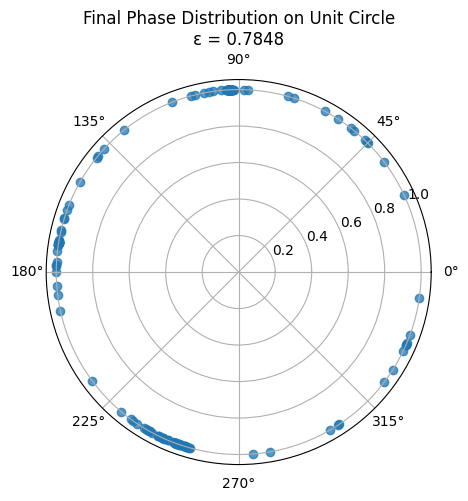

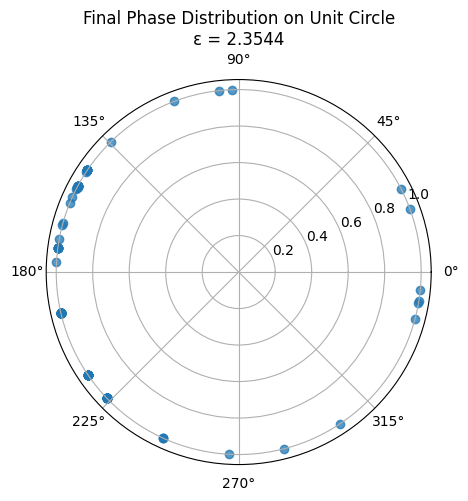

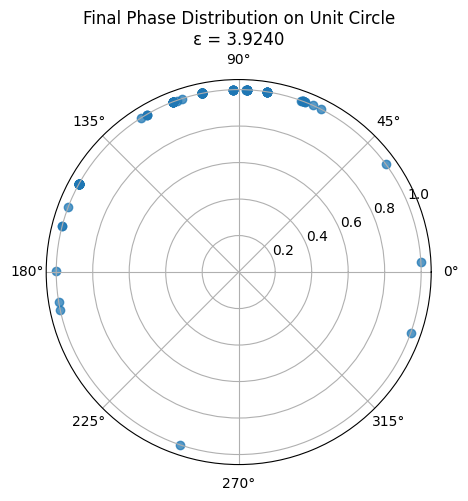

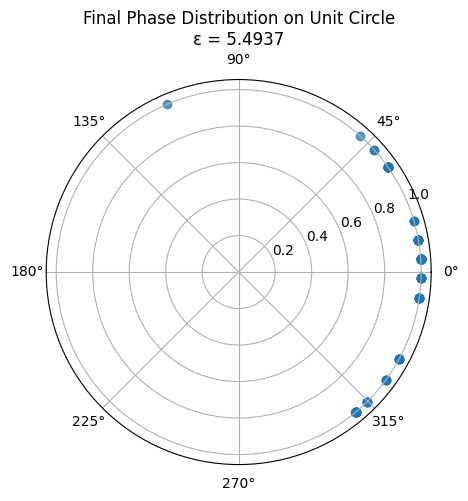

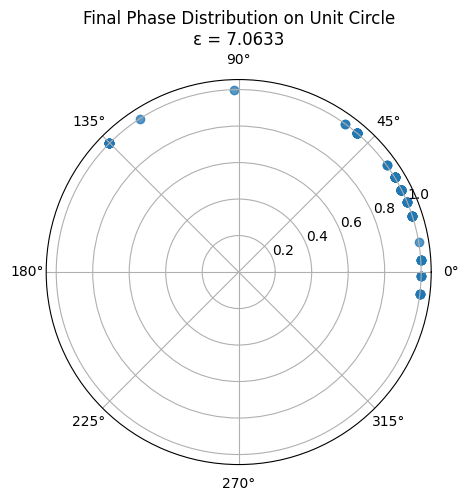

In [4]:
# Kuramoto model simulation with PSD-derived natural frequencies
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.stats import gaussian_kde
from scipy.signal import welch, find_peaks

# === Parameters ===
fs = 500  # Sampling frequency (Hz)
T_sim = 1500  # Number of time steps
dt = 0.01  # Time step size

# === Compute natural frequencies using FFT ===
N = len(EEG.columns)

natural_freqs_psd = []

# === Find natural frequency (peak or weighted average in 0.5–30 Hz) ===
for channel in EEG.columns:
    signal = EEG[channel].values
    freqs, psd = welch(signal, fs=fs, nperseg=1024)

    # Apply frequency mask: 0.5 to 100 Hz
    mask = (freqs >= 0.5) & (freqs <= 100.0)
    freqs_band = freqs[mask]
    psd_band = psd[mask]

    # Find peaks in masked PSD
    peak_idx, _ = find_peaks(psd_band)

    if len(peak_idx) > 0:
        dominant_idx = peak_idx[np.argmax(psd_band[peak_idx])]
        natural_freq = freqs_band[dominant_idx]
    else:
        # Use weighted average if no peaks detected
        natural_freq = np.sum(freqs_band * psd_band) / np.sum(psd_band)

    natural_freqs_psd.append(natural_freq)

# Convert to NumPy array
natural_freqs_psd = np.array(natural_freqs_psd)
omega = natural_freqs_psd  # <-- Using PSD-based frequencies

# === Step 2: Estimate g(omega) and critical epsilon ===
kde = gaussian_kde(omega)
density_values = kde.evaluate(omega)
g_omega = np.max(density_values)
epsilon_critical = 2 / (np.pi * g_omega)

print(f"Estimated g(omega): {g_omega:.4f}")
print(f"Estimated critical coupling ε_c: {epsilon_critical:.4f}")

epsilons = np.linspace(0.1 * epsilon_critical, 0.9 * epsilon_critical, 5)

@njit
def pll_frequency(signal, fs, f0, Kp=2.0, Ki=1.0):
    N = len(signal)
    dt = 1 / fs
    vco_phase = 0.0
    vco_freq = 2 * np.pi * f0
    integrator = 0.0
    freq_series = np.zeros(N)

    for n in range(N):
        ref = np.cos(vco_phase)
        error = signal[n] * ref
        integrator += Ki * error * dt
        control = Kp * error + integrator
        vco_freq = 2 * np.pi * f0 + control
        vco_phase += vco_freq * dt
        vco_phase %= 2 * np.pi
        freq_series[n] = vco_freq / (2 * np.pi)  # Hz

    return freq_series

# === Step 2: Run PLL per channel and get initial phases ===
initial_phases = []
pll_freqs_all = []

for i, channel in enumerate(channels):
    f0 = natural_freqs[i]

    if np.isnan(f0) or f0 <= 0:
        # Skip channels with invalid frequency
        continue

    signal = EEG[channel].values
    signal = signal - np.mean(signal)

    freq_series = pll_frequency(signal, fs, f0)
    pll_freqs_all.append(freq_series)
    cum_phase = np.cumsum(freq_series * 2 * np.pi / fs)  # rad
    phase = cum_phase[-1] % (2 * np.pi)
    initial_phases.append(phase)

initial_phases = np.array(initial_phases)

x = np.array(initial_phases)

# === Prepare storage for phase over time ===
phase_history = np.zeros((T_sim, N))
phase_history[0] = x

for epsilon in epsilons:
    x = np.array(initial_phases)
    phase_history = np.zeros((T_sim, N))
    phase_history[0] = x

    # === Simulate phase dynamics (Kuramoto model) ===
    for t in range(1, T_sim):
        x_new = np.copy(x)
        for k in range(N):
            coupling_sum = np.sum(np.sin(x - x[k])) - np.sin(0)  # Exclude self-term
            x_new[k] += dt * (omega[k] + (epsilon / N) * coupling_sum)
        x = x_new
        phase_history[t] = x

    # === Plot 3: Polar plot of final wrapped phases ===
    final_phases = np.mod(phase_history[-1], 2 * np.pi)
    plt.figure(figsize=(5, 5))
    ax = plt.subplot(111, polar=True)
    ax.scatter(final_phases, np.ones_like(final_phases), alpha=0.75)
    ax.set_title(f'Final Phase Distribution on Unit Circle\nε = {epsilon:.4f}')
    plt.show()


In [5]:
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.utils import resample

# Assuming `omega` is your array of natural frequencies
n_bootstraps = 1000
g_omega_values = []

# Bootstrap resampling
for _ in range(n_bootstraps):
    omega_sample = resample(omega)
    kde = gaussian_kde(omega_sample)
    density_values = kde.evaluate(omega_sample)
    g_omega_values.append(np.max(density_values))

g_omega_values = np.array(g_omega_values)
g_omega_mean = np.mean(g_omega_values)
g_omega_std = np.std(g_omega_values)

epsilon_critical_values = 2 / (np.pi * g_omega_values)
epsilon_critical_mean = np.mean(epsilon_critical_values)
epsilon_critical_std = np.std(epsilon_critical_values)

print(f"Estimated g(omega): {g_omega_mean:.4f} ± {g_omega_std:.4f}")
print(f"Critical coupling ε_c ≈ {epsilon_critical_mean:.4f} ± {epsilon_critical_std:.4f}")


Estimated g(omega): 0.0827 ± 0.0112
Critical coupling ε_c ≈ 7.8294 ± 1.0132


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import njit

# === Parameters ===
epsilon = 0.5 * epsilon_critical  # Coupling strength
fs = 500     # Sampling rate (Hz)

# === Extract EEG info ===
channels = EEG.columns
N = len(channels)
@njit
def pll_frequency(signal, fs, f0, Kp=2.0, Ki=1.0):
    N = len(signal)
    dt = 1 / fs
    vco_phase = 0.0
    vco_freq = 2 * np.pi * f0
    integrator = 0.0
    freq_series = np.zeros(N)

    for n in range(N):
        ref = np.cos(vco_phase)
        error = signal[n] * ref
        integrator += Ki * error * dt
        control = Kp * error + integrator
        vco_freq = 2 * np.pi * f0 + control
        vco_phase += vco_freq * dt
        vco_phase %= 2 * np.pi
        freq_series[n] = vco_freq / (2 * np.pi)  # Hz

    return freq_series

# === Step 1: Run PLL per channel to get initial phases ===
initial_phases = []
pll_freqs_all = []

for i, channel in enumerate(channels):
    f0 = natural_freqs[i]

    if np.isnan(f0) or f0 <= 0:
        initial_phases.append(np.nan)
        continue

    signal = EEG[channel].values
    signal = signal - np.mean(signal)  # Demean

    freq_series = pll_frequency(signal, fs, f0)
    pll_freqs_all.append(freq_series)

    cum_phase = np.cumsum(freq_series * 2 * np.pi / fs)  # radians
    phase = cum_phase[-1] % (2 * np.pi)
    initial_phases.append(phase)

initial_phases = np.array(initial_phases)
valid_idx = ~np.isnan(initial_phases)

# === Step 2: Compute TLEs for each channel ===
x = initial_phases
TLEs = np.zeros(N)

for k in range(N):
    if np.isnan(x[k]):
        TLEs[k] = np.nan
        continue
    cos_sum = 0
    count = 0
    for j in range(N):
        if j != k and not np.isnan(x[j]):
            cos_sum += np.cos(x[j] - x[k])
            count += 1
    if count > 0:
        TLEs[k] = - (epsilon / N) * cos_sum
    else:
        TLEs[k] = np.nan

# === Step 3: Threshold TLEs to determine simulated epileptogenicity ===
Epileptogenic_simulated = (TLEs <= 0).astype(int)
Epileptogenic_simulated[np.isnan(TLEs)] = -1  # Mark invalid entries

# Combine with channel names
Epileptogenic_sim = np.column_stack((channels, Epileptogenic_simulated.astype(str)))

# === Step 4: Compare with real labels ===
Epileptogenic_real = np.column_stack((channels, df['Epileptogenic'].to_numpy().astype(str)))

# Filter out invalid entries
valid_comparison_idx = Epileptogenic_simulated != -1
sim_vals = Epileptogenic_simulated[valid_comparison_idx]
real_vals = Epileptogenic_real[valid_comparison_idx, 1].astype(int)

# === Step 5: Cross-tabulation ===
cross_table = np.zeros((2, 2), dtype=int)
for s, r in zip(sim_vals, real_vals):
    cross_table[s, r] += 1

# Format nicely
df_cross = pd.DataFrame(cross_table,
                        index=['Sim=0 (Non-Epi)', 'Sim=1 (Epi)'],
                        columns=['Real=0 (Non-Epi)', 'Real=1 (Epi)'])

print("\nCross-tabulation Results using PSD and PLL (Simulated vs Real Epileptogenicity):")
print(df_cross)



Cross-tabulation Results using PSD and PLL (Simulated vs Real Epileptogenicity):
                 Real=0 (Non-Epi)  Real=1 (Epi)
Sim=0 (Non-Epi)                42             9
Sim=1 (Epi)                    77            43
